## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, SimpleRNN, Bidirectional

### Datos

In [2]:
# Cargamos dataset
# Dataset de StephenKing
# IT book
file_path = "../../clase_3/ejercicios/StephenKing_books/Stephen_King_TheShining.txt"

with open(file_path, 'r', encoding='utf-8') as file:
    book = file.read()

In [3]:
# Preprocesamiento con spacy ya que le dataset
# es texto denso sin signos y no esta divido en oraciones
import spacy

nlp = spacy.load('en_core_web_sm')
doc = nlp(book)
sentences = [sent.text for sent in doc.sents] # separamos por oraciones

In [4]:
# Visualizamos documentos en formato dataframe
df = pd.DataFrame(sentences)
df.head(10)

,0
0,This is for Joe Hill King who shines on My edi...
1,Some of the most beautiful resort hotels in th...
2,rang it was observed that the giddiest grew pa...
3,But when the echoes had fully ceased a light l...
4,E A POE The Masque of the Red Death
5,The sleep of reason breeds monsters GOYA
6,Itll shine when it shines FOLK SAYING Part One...
7,This had better be good you There was a red ca...
8,sorry I asked if your wife fully understood wh...
9,And theres your son of course He glanced down ...


In [5]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 3184


### Preprocesamiento
**obs**

Probando modelo con un largo de secuencia de 8 =
7 (input) + 1(output a predecir)

In [6]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 8

In [7]:
# Vistazo a las primeras filas
df.loc[:15,0]

0     This is for Joe Hill King who shines on My edi...
1     Some of the most beautiful resort hotels in th...
2     rang it was observed that the giddiest grew pa...
3     But when the echoes had fully ceased a light l...
4                   E A POE The Masque of the Red Death
5              The sleep of reason breeds monsters GOYA
6     Itll shine when it shines FOLK SAYING Part One...
7     This had better be good you There was a red ca...
8     sorry I asked if your wife fully understood wh...
9     And theres your son of course He glanced down ...
10    Daniel Your wife isnt a bit intimidated by the...
11    Well look at the floor plans He brought back f...
12    and he had to clamp his tongue between his tee...
13    and it seems that each successive manager has ...
14    Of course you wouldnt allow your son up in the...
15    But he kept quiet He needed the job Ullman put...
Name: 0, dtype: object

In [73]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
#corpus

In [9]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:8]

['this', 'is', 'for', 'joe', 'hill', 'king', 'who', 'shines']

In [10]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 163093


In [11]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [12]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['this', 'is', 'for', 'joe', 'hill', 'king', 'who', 'shines'],
 ['is', 'for', 'joe', 'hill', 'king', 'who', 'shines', 'on'],
 ['for', 'joe', 'hill', 'king', 'who', 'shines', 'on', 'my'],
 ['joe', 'hill', 'king', 'who', 'shines', 'on', 'my', 'editor'],
 ['hill', 'king', 'who', 'shines', 'on', 'my', 'editor', 'on'],
 ['king', 'who', 'shines', 'on', 'my', 'editor', 'on', 'this'],
 ['who', 'shines', 'on', 'my', 'editor', 'on', 'this', 'book'],
 ['shines', 'on', 'my', 'editor', 'on', 'this', 'book', 'as'],
 ['on', 'my', 'editor', 'on', 'this', 'book', 'as', 'on'],
 ['my', 'editor', 'on', 'this', 'book', 'as', 'on', 'the'],
 ['editor', 'on', 'this', 'book', 'as', 'on', 'the', 'previous'],
 ['on', 'this', 'book', 'as', 'on', 'the', 'previous', 'two'],
 ['this', 'book', 'as', 'on', 'the', 'previous', 'two', 'was'],
 ['book', 'as', 'on', 'the', 'previous', 'two', 'was', 'mr'],
 ['as', 'on', 'the', 'previous', 'two', 'was', 'mr', 'william'],
 ['on', 'the', 'previous', 'two', 'was', 'mr', 'willi

In [13]:
# Proceso de tokenización
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[51, 62, 24, 6358, 3420, 4406, 97, 2433],
 [62, 24, 6358, 3420, 4406, 97, 2433, 14],
 [24, 6358, 3420, 4406, 97, 2433, 14, 76],
 [6358, 3420, 4406, 97, 2433, 14, 76, 2825],
 [3420, 4406, 97, 2433, 14, 76, 2825, 14],
 [4406, 97, 2433, 14, 76, 2825, 14, 51],
 [97, 2433, 14, 76, 2825, 14, 51, 308],
 [2433, 14, 76, 2825, 14, 51, 308, 28],
 [14, 76, 2825, 14, 51, 308, 28, 14],
 [76, 2825, 14, 51, 308, 28, 14, 1],
 [2825, 14, 51, 308, 28, 14, 1, 2144],
 [14, 51, 308, 28, 14, 1, 2144, 89],
 [51, 308, 28, 14, 1, 2144, 89, 7],
 [308, 28, 14, 1, 2144, 89, 7, 140],
 [28, 14, 1, 2144, 89, 7, 140, 4407],
 [14, 1, 2144, 89, 7, 140, 4407, 3422],
 [1, 2144, 89, 7, 140, 4407, 3422, 6359],
 [2144, 89, 7, 140, 4407, 3422, 6359, 3],
 [89, 7, 140, 4407, 3422, 6359, 3, 124],
 [7, 140, 4407, 3422, 6359, 3, 124, 6]]

In [14]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 163085


### 3 - Input y target

In [15]:
# separamos los 7 primeros terminos que serán nuestra X
# y la palabra a determinar nuestra Y
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(163085, 7)
(163085,)


In [16]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'and',
 3: 'a',
 4: 'he',
 5: 'to',
 6: 'of',
 7: 'was',
 8: 'his',
 9: 'it',
 10: 'in',
 11: 'had',
 12: 'that',
 13: 'you',
 14: 'on',
 15: 'i',
 16: 'she',
 17: 'her',
 18: 'him',
 19: 'with',
 20: 'at',
 21: 'but',
 22: 'danny',
 23: 'up',
 24: 'for',
 25: 'said',
 26: 'out',
 27: 'jack',
 28: 'as',
 29: 'been',
 30: 'all',
 31: 'be',
 32: 'like',
 33: 'there',
 34: 'they',
 35: 'from',
 36: 'would',
 37: 'were',
 38: 'back',
 39: 'if',
 40: 'them',
 41: 'down',
 42: 'not',
 43: 'no',
 44: 'one',
 45: 'into',
 46: 'what',
 47: 'have',
 48: 'when',
 49: 'could',
 50: 'now',
 51: 'this',
 52: 'over',
 53: 'then',
 54: 'its',
 55: 'just',
 56: 'your',
 57: 'or',
 58: 'by',
 59: 'an',
 60: 'wendy',
 61: 'me',
 62: 'is',
 63: 'so',
 64: 'hallorann',
 65: 'get',
 66: 'right',
 67: 'again',
 68: 'around',
 69: 'do',
 70: 'here',
 71: 'about',
 72: 'little',
 73: 'dont',
 74: 'come',
 75: 'daddy',
 76: 'my',
 77: 'through',
 78: 'time',
 79: 'looked',
 80: 'way',
 81: 'only'

In [17]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

12542

In [18]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [19]:
# Transformar los datos a oneHotEncoding
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(163085, 12542)

### 4 - Entrenar el modelo

In [20]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

7

In [21]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

12542

**obs**

Se utilizará una simple RNN en vez de la LSTM y un Dropout de 0.5.

In [72]:
model = Sequential()

# Embedding:
# input_seq_len = 7 --> ingreso 7 palabras
# input_dim = vocab_size --> 12542 palabras distintas
# output_dim = 8 --> crear embeddings de tamaño 7 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=8, input_length=input_seq_len))

model.add(SimpleRNN(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(SimpleRNN(64)) # La última capa no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 12542 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 7, 8)              100344    
                                                                 
 simple_rnn (SimpleRNN)      (None, 7, 64)             4672      
                                                                 
 dropout (Dropout)           (None, 7, 64)             0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 12542)             413886    
                                                                 
Total params: 529238 (2.02 MB)
Trainable params: 529238 

In [73]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
4078/4078 [==============================] - 31s 7ms/step - loss: 6.7887 - accuracy: 0.0594 - val_loss: 6.5993 - val_accuracy: 0.0719
Epoch 2/50
4078/4078 [==============================] - 32s 8ms/step - loss: 6.3069 - accuracy: 0.0741 - val_loss: 6.4990 - val_accuracy: 0.0903
Epoch 3/50
4078/4078 [==============================] - 34s 8ms/step - loss: 6.0612 - accuracy: 0.0883 - val_loss: 6.5411 - val_accuracy: 0.0962
Epoch 4/50
4078/4078 [==============================] - 37s 9ms/step - loss: 5.9201 - accuracy: 0.0953 - val_loss: 6.5592 - val_accuracy: 0.1030
Epoch 5/50
4078/4078 [==============================] - 37s 9ms/step - loss: 5.8112 - accuracy: 0.1018 - val_loss: 6.6371 - val_accuracy: 0.1076
Epoch 6/50
4078/4078 [==============================] - 35s 9ms/step - loss: 5.7322 - accuracy: 0.1053 - val_loss: 6.7094 - val_accuracy: 0.1061
Epoch 7/50
4078/4078 [==============================] - 35s 9ms/step - loss: 5.6725 - accuracy: 0.1084 - val_loss: 6.7677 - val_ac

/Users/hectorsanchez/procesamiento_lenguaje_natural/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hectorsanchez/procesamiento_lenguaje_natural/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hectorsanchez/procesamiento_lenguaje_natural/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/hectorsanchez/procesamiento_lenguaje_natural/venv/lib/python3.10/site-packages/seaborn

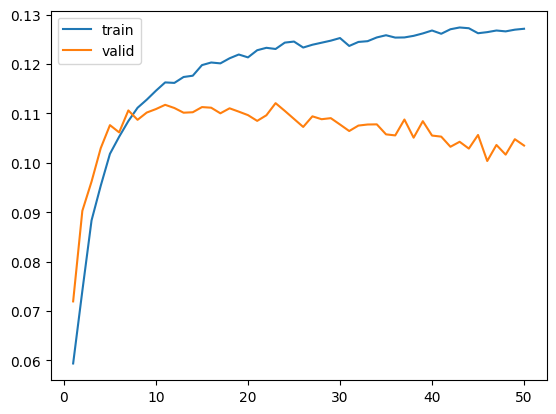

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

**obs**

El modelo tuvo overfitting. Esto se puede solucionar con early stopping y incrementando el Dropout

In [22]:
model_2 = Sequential()

# Embedding:
# input_seq_len = 7 --> ingreso 7 palabras
# input_dim = vocab_size --> 12542 palabras distintas
# output_dim = 8 --> crear embeddings de tamaño 7 (tamaño variable y ajustable)
model_2.add(Embedding(input_dim=vocab_size+1, output_dim=8, input_length=input_seq_len))

model_2.add(Bidirectional(SimpleRNN(64, return_sequences=True)))
model_2.add(Dropout(0.5))
model_2.add(Bidirectional(SimpleRNN(64))) # La última capa no lleva return_sequences
model_2.add(Dropout(0.5))
model_2.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 12542 palabras posibles
model_2.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 7, 8)              100344    
                                                                 
 bidirectional (Bidirection  (None, 7, 128)            9344      
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 7, 128)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               24704     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4

In [23]:
hist_2 = model_2.fit(x_data, y_data, epochs=20, validation_split=0.2)

Epoch 1/20
4078/4078 [==============================] - 34s 8ms/step - loss: 6.7902 - accuracy: 0.0614 - val_loss: 6.5682 - val_accuracy: 0.0799
Epoch 2/20
4078/4078 [==============================] - 39s 9ms/step - loss: 6.3386 - accuracy: 0.0745 - val_loss: 6.5186 - val_accuracy: 0.0893
Epoch 3/20
4078/4078 [==============================] - 40s 10ms/step - loss: 6.1265 - accuracy: 0.0878 - val_loss: 6.5519 - val_accuracy: 0.1028
Epoch 4/20
4078/4078 [==============================] - 45s 11ms/step - loss: 6.0017 - accuracy: 0.0959 - val_loss: 6.5757 - val_accuracy: 0.1079
Epoch 5/20
4078/4078 [==============================] - 46s 11ms/step - loss: 5.9072 - accuracy: 0.1003 - val_loss: 6.6079 - val_accuracy: 0.1093
Epoch 6/20
4078/4078 [==============================] - 46s 11ms/step - loss: 5.8302 - accuracy: 0.1052 - val_loss: 6.7349 - val_accuracy: 0.1100
Epoch 7/20
4078/4078 [==============================] - 45s 11ms/step - loss: 5.7734 - accuracy: 0.1086 - val_loss: 6.7486 - v

/Users/hectorsanchez/procesamiento_lenguaje_natural/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hectorsanchez/procesamiento_lenguaje_natural/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hectorsanchez/procesamiento_lenguaje_natural/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/hectorsanchez/procesamiento_lenguaje_natural/venv/lib/python3.10/site-packages/seaborn

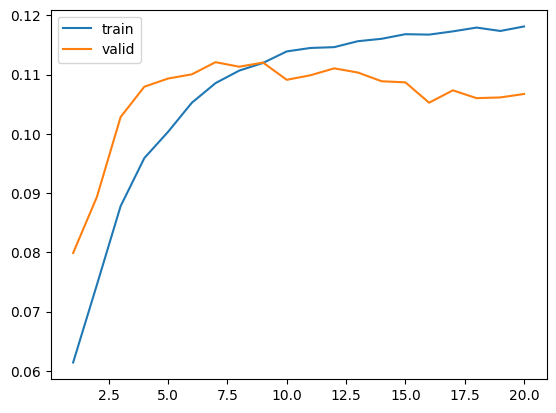

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count_2 = range(1, len(hist_2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count_2,  y=hist_2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count_2,  y=hist_2.history['val_accuracy'], label='valid')
plt.show()

**obs**

Se le introdujo otro Dropout, se disminuyó la cantidad de epocas y se le añadio Bidirectional pero el modelo sigue teniendo overfitting.

Pruebo con un input menor de 3 + output de 1 = 4

In [32]:
# largo de la secuencia, incluye seq input + word output
train_len_2 = 4

# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences_2 = []
for i in range(train_len_2, len(tokens)):
  seq_2 = tokens[i-train_len_2:i]
  text_sequences_2.append(seq_2)

In [33]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences_2[:20]

[['this', 'is', 'for', 'joe'],
 ['is', 'for', 'joe', 'hill'],
 ['for', 'joe', 'hill', 'king'],
 ['joe', 'hill', 'king', 'who'],
 ['hill', 'king', 'who', 'shines'],
 ['king', 'who', 'shines', 'on'],
 ['who', 'shines', 'on', 'my'],
 ['shines', 'on', 'my', 'editor'],
 ['on', 'my', 'editor', 'on'],
 ['my', 'editor', 'on', 'this'],
 ['editor', 'on', 'this', 'book'],
 ['on', 'this', 'book', 'as'],
 ['this', 'book', 'as', 'on'],
 ['book', 'as', 'on', 'the'],
 ['as', 'on', 'the', 'previous'],
 ['on', 'the', 'previous', 'two'],
 ['the', 'previous', 'two', 'was'],
 ['previous', 'two', 'was', 'mr'],
 ['two', 'was', 'mr', 'william'],
 ['was', 'mr', 'william', 'g']]

In [34]:
# Proceso de tokenización
tok_2 = Tokenizer() 
tok_2.fit_on_texts(text_sequences_2) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences_2 = tok_2.texts_to_sequences(text_sequences_2)

# Damos un vistazo
sequences_2[:20]

[[51, 62, 24, 4407],
 [62, 24, 4407, 2825],
 [24, 4407, 2825, 3422],
 [4407, 2825, 3422, 96],
 [2825, 3422, 96, 2433],
 [3422, 96, 2433, 14],
 [96, 2433, 14, 76],
 [2433, 14, 76, 2826],
 [14, 76, 2826, 14],
 [76, 2826, 14, 51],
 [2826, 14, 51, 308],
 [14, 51, 308, 28],
 [51, 308, 28, 14],
 [308, 28, 14, 1],
 [28, 14, 1, 2144],
 [14, 1, 2144, 89],
 [1, 2144, 89, 7],
 [2144, 89, 7, 140],
 [89, 7, 140, 4408],
 [7, 140, 4408, 3423]]

In [74]:
print("Cantidad de rows del dataset:", len(sequences_2))

Cantidad de rows del dataset: 163089


In [37]:
# separamos los 3 primeros terminos que serán nuestra X
# y la palabra a determinar nuestra Y
arr_sequences_2 = np.array(sequences_2)
x_data_2 = arr_sequences_2[:,:-1]
y_data_int_2 = arr_sequences_2[:,-1] # aún falta el oneHotEncoder

print(x_data_2.shape)
print(y_data_int_2.shape)

(163089, 3)
(163089,)


In [38]:
# Cantidad de palabras en el vocabulario
vocab_size_2 = len(tok_2.word_counts)
vocab_size_2

12542

In [39]:
# Transformar los datos a oneHotEncoding
y_data_int_offset_2 = y_data_int_2 - 1
y_data_2 = to_categorical(y_data_int_offset_2, num_classes=vocab_size_2) 
y_data_2.shape

(163089, 12542)

In [40]:
# largo de la secuencia de entrada
input_seq_len_2 = x_data_2.shape[1] 
input_seq_len_2

3

In [41]:
# Largo del vector de salida --> vocab_size
output_size_2 = vocab_size_2
output_size_2

12542

In [42]:
model_3 = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 12542 palabras distintas
# output_dim = 8 --> crear embeddings de tamaño 7 (tamaño variable y ajustable)
model_3.add(Embedding(input_dim=vocab_size_2+1, output_dim=8, input_length=input_seq_len_2))

model_3.add(SimpleRNN(64, return_sequences=True))
model_3.add(Dropout(0.5))
model_3.add(SimpleRNN(64)) # La última capa no lleva return_sequences
model_3.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 12542 palabras posibles
model_3.add(Dense(vocab_size_2, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3, 8)              100344    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 3, 64)             4672      
                                                                 
 dropout_2 (Dropout)         (None, 3, 64)             0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 12542)             413886    
                                                                 
Total params: 529238 (2.02 MB)
Trainable params: 52923

In [43]:
hist_3 = model_3.fit(x_data_2, y_data_2, epochs=20, validation_split=0.2)

Epoch 1/20
4078/4078 [==============================] - 26s 6ms/step - loss: 6.7866 - accuracy: 0.0601 - val_loss: 6.5715 - val_accuracy: 0.0739
Epoch 2/20
4078/4078 [==============================] - 23s 6ms/step - loss: 6.3057 - accuracy: 0.0753 - val_loss: 6.5124 - val_accuracy: 0.0947
Epoch 3/20
4078/4078 [==============================] - 24s 6ms/step - loss: 6.0526 - accuracy: 0.0885 - val_loss: 6.5465 - val_accuracy: 0.0980
Epoch 4/20
4078/4078 [==============================] - 23s 6ms/step - loss: 5.9001 - accuracy: 0.0957 - val_loss: 6.5570 - val_accuracy: 0.1018
Epoch 5/20
4078/4078 [==============================] - 24s 6ms/step - loss: 5.7976 - accuracy: 0.0990 - val_loss: 6.6269 - val_accuracy: 0.1036
Epoch 6/20
4078/4078 [==============================] - 25s 6ms/step - loss: 5.7226 - accuracy: 0.1014 - val_loss: 6.7017 - val_accuracy: 0.1033
Epoch 7/20
4078/4078 [==============================] - 24s 6ms/step - loss: 5.6630 - accuracy: 0.1045 - val_loss: 6.8076 - val_ac

/Users/hectorsanchez/procesamiento_lenguaje_natural/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hectorsanchez/procesamiento_lenguaje_natural/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/hectorsanchez/procesamiento_lenguaje_natural/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/hectorsanchez/procesamiento_lenguaje_natural/venv/lib/python3.10/site-packages/seaborn

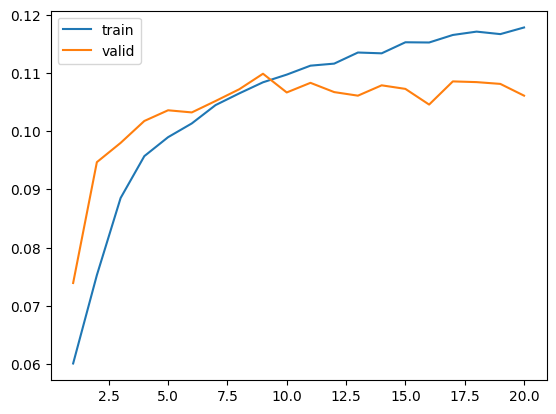

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count_3 = range(1, len(hist_3.history['accuracy']) + 1)
sns.lineplot(x=epoch_count_3,  y=hist_3.history['accuracy'], label='train')
sns.lineplot(x=epoch_count_3,  y=hist_3.history['val_accuracy'], label='valid')
plt.show()

**obs**

Al final el tercer modelo tambien tiene overfitting. Sigo con más pruebas con el modelo 2. Recordando que este modelo tiene una SimpleRNN bidirectitonal y dos Dropouts. Además, su secuencia de entrada es igual a 7.

### 5 - Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [ ]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
#import sys
#!{sys.executable} -m pip install gradio --quiet

In [46]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=7, padding='pre')
    
    # Predicción softmax
    y_hat = model_2.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

/var/folders/th/f02nw4xd4xg6c6tc6mn55h800000gn/T/ipykernel_23445/1746165545.py:24: GradioDeprecationWarning: `layout` parameter is deprecated, and it has no effect
  iface = gr.Interface(


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 13ms/step
Keyboard interruption in main thread... closing server.


**obs**

Como se puede observar, tras 4 intentos el algoritmo no pudo predecir la octava palabra de forma correcta. La frase correcta era: "This is for Joe Hill King who shines".

Donde el algoritmo predijo: "This is for Joe Hill King who in".

Probamos con el modelo 3 que tenía una secuencia de 3 palabras de entrada y un total de 4 sumando la salida.

In [47]:
import gradio as gr

def model_response2(human_text):

    # Encodeamos
    encoded = tok_2.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model_3.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

/var/folders/th/f02nw4xd4xg6c6tc6mn55h800000gn/T/ipykernel_23445/3992905720.py:24: GradioDeprecationWarning: `layout` parameter is deprecated, and it has no effect
  iface = gr.Interface(


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 15ms/step
Keyboard interruption in main thread... closing server.


**obs**

Con una secuencia de 3 palabras a la entrada y la arquitectura del modelo 3 se tiene el mismo resultado, donde se le presenta la frase: "hill king who".

Respuesta correcta: "hill king who shines".
Respuesta predicha: "hill king who in".

### 6 - Generación de secuencias nuevas

**obs**

Seguimos probando con el modelo 2 y 3 para n_words

In [48]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model_2.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [63]:
input_text='This is for Joe Hill King who'

generate_seq(model_2, tok, input_text, max_length=7, n_words=2)

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


'This is for Joe Hill King who in '

In [64]:
input_text='Hill King who'

generate_seq(model_3, tok_2, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 11ms/step


'Hill King who and and'

**obs**

Para n_words vemos que tanto el modelo 2 y 3 sigue teniendo un mal desempeño para hallar la siguiente palabra

### 7 - Beam search y muestreo aleatorio

In [68]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=7):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [70]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  # idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0] 

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens) 

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update)) 

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens) 

    return history_tokens

In [71]:
# predicción con beam search
salidas = beam_search(model_2,num_beams=10,num_words=6,input="This is for Joe Hill King who")

1/1 [==============================] - 0s 11ms/step


In [72]:
# veamos las salidas
decode(salidas[0])

['this is for joe hill king who for tried he in']

### 8 - Conclusiones

En general se probaron distintos modelos que contenian una SimpleRNN, pero variaban la cantidad de Dropout, cantidad de sequencias de entradas y si eran bidireccional o no.

Se tuvieron malos resultados en general, posiblemente provenientes del overfitting que se obtuvo en cada uno los casos.

Los resultados podrían mejorar con otro dataset o probando con otras arquitecturas como una LSTM.